# SC 1 through 5 Model Comparisons #

Previous analyses have been pairwise classifications (linear vs. lineage, early/late vs split/coalescence, rectangular vs. square neighbor models).  Here, we perform a multiclass analysis, and compare the performance of GBM with random forest classifiers.  

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle as pickle
from copy import deepcopy
from sklearn.utils import shuffle
import sklearn_mmadsen.graphs as skmg
import sklearn_mmadsen.graphics as skmplt

%matplotlib inline
# plt.style.use("fivethirtyeight")
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
sc_1_3_graphs = pickle.load(open("train-cont-sc-1-3-graphs.pkl",'r'))
sc_1_3_labels = pickle.load(open("train-cont-sc-1-3-labels.pkl",'r'))
print "sc_1_3 cases: ", len(sc_1_3_graphs)
# sc_2_graphs = pickle.load(open("train-cont-sc-2-graphs.pkl",'r'))
# sc_2_labels = pickle.load(open("train-cont-sc-2-labels.pkl",'r'))
# print "sc_2 cases: ", len(sc_2_graphs)
sc_4_5_graphs = pickle.load(open("train-sc-4-5-cont-graphs.pkl",'r'))
sc_4_5_labels = pickle.load(open("train-sc-4-5-cont-labels.pkl",'r'))
print "sc_4_5 cases: ", len(sc_4_5_graphs)

sc_1_3 cases:  946
sc_4_5 cases:  1000


**NOTE**:  Removing sc-2 for the moment because the sample sizes are very small and it's hard to get a reliable test set compared to the other experiments.  Will run more simulations

Now we need to construct a single data set with a 10% test set split, and we'd like it to be fairly even among
the class labels.  

## Label Catalog ##

0 = Linear 

1 = Lineage

2 = Rectangular nearest neighbor

3 = Square nearest neighbor

In [3]:
text_labels = ['complete', 'lineage-split', 'rect-nn', 'square-nn']

In [4]:
full_train_graphs = []
full_train_labels = []
full_test_graphs = []
full_test_labels = []

In [5]:
def add_to_dataset(graphs, labels):
    train_graphs, train_labels, test_graphs, test_labels = skmg.graph_train_test_split(graphs, labels, test_fraction=0.1)
    print "train size: %s" % len(train_graphs)
    print "test size: %s" % len(test_graphs)
    full_train_graphs.extend(train_graphs)
    full_train_labels.extend(train_labels)
    full_test_graphs.extend(test_graphs)
    full_test_labels.extend(test_labels)

In [6]:
add_to_dataset(sc_1_3_graphs, sc_1_3_labels)
#add_to_dataset(sc_2_graphs, sc_2_labels)
add_to_dataset(sc_4_5_graphs, sc_4_5_labels)

random indices: [ 18 274 303  61 375 221 435 860 187  79 717 844 512 496 657 301  31 274
 559 181 139 490 707 432 656 426 895 503 515 686 899 428 273  29 232 901
   0 643  87 623 382 173 537 402 502 934 377 837 233 110  53 248 625 410
 882 199 309 674 313 588 912 380 193 287 165 537 401 549 552 765 156 392
 349 110 816 226 289 746 827 373 170 849 122 497 276 601 107 493 467 231
 803 420   0 234]
min ix: 0  max ix: 934
train size: 856
test size: 94
random indices: [449 778 543 322 498 695 878 762 946  75 229 885 384 447 718 340 702 327
 929 508 440 274  83 207 647  50 194 494 574 470 736 328 985 829 172 185
  87 403 283 315 746 917   1 694 422 752 500 695 583 942 429 200 343 401
 791 206 403 384 110 478 124 193 533 267 317  89 220  49 707 595 952 879
 208 166 864 515 498 686 517   7 352 666 841 593  92 240 665  65 195  12
  19 701 663 948 348 607 527 200 526 641]
min ix: 1  max ix: 985
train size: 905
test size: 100


## Feature Engineering ##

The goal here is to construct a standard training and test data matrix of numeric values, which will contain the sorted Laplacian eigenvalues of the graphs in each data set.  One feature will thus represent the largest eigenvalue for each graph, a second feature will represent the second largest eigenvalue, and so on.  


In [7]:
train_matrix = skmg.graphs_to_eigenvalue_matrix(full_train_graphs, num_eigenvalues=20)
test_matrix = skmg.graphs_to_eigenvalue_matrix(full_test_graphs, num_eigenvalues=20)
print train_matrix.shape
print test_matrix.shape

(debug) eigenvalues - minimum shared eigenvalues: 10 num_eigenvalues: 20 ev_used: 10
(debug) eigenvalues - minimum shared eigenvalues: 10 num_eigenvalues: 20 ev_used: 10
(1761, 10)
(194, 10)


## First Classifier ##

We're going to be using a gradient boosted classifier, which has some of best accuracy of any of the standard classifier methods.  Ultimately we'll figure out the best hyperparameters using cross-validation, but first we just want to see whether the approach gets us anywhere in the right ballpark -- remember, we can 80% accuracy with just eigenvalue distance, so we have to be in that neighborhood or higher to be worth the effort of switching to a more complex model.  

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [9]:
clf = GradientBoostingClassifier(n_estimators = 250)
clf.fit(train_matrix, full_train_labels)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [10]:
pred_label = clf.predict(test_matrix)

In [11]:
cm = confusion_matrix(full_test_labels, pred_label)
cmdf = pd.DataFrame(cm)
cmdf.columns = map(lambda x: 'predicted {}'.format(x), cmdf.columns)
cmdf.index = map(lambda x: 'actual {}'.format(x), cmdf.index)

print cmdf
print classification_report(full_test_labels, pred_label)
print "Accuracy on test: %0.3f" % accuracy_score(full_test_labels, pred_label)

          predicted 0  predicted 1  predicted 2  predicted 3
actual 0           37            9            0            0
actual 1            4           44            0            0
actual 2            0            0           37           17
actual 3            0            0           30           16
             precision    recall  f1-score   support

          0       0.90      0.80      0.85        46
          1       0.83      0.92      0.87        48
          4       0.55      0.69      0.61        54
          5       0.48      0.35      0.41        46

avg / total       0.69      0.69      0.68       194

Accuracy on test: 0.691


## Finding Optimal Hyperparameters ##

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

In [13]:
pipeline = Pipeline([
        ('clf', GradientBoostingClassifier())
    ])

params = {
     'clf__learning_rate': [5.0,2.0,1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01],
     'clf__n_estimators': [10,25,50,100,250,500]
}

grid_search = GridSearchCV(pipeline, params, n_jobs = -1, verbose = 1)

In [14]:
grid_search.fit(train_matrix, full_train_labels)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   25.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('clf', GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__learning_rate': [5.0, 2.0, 1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01], 'clf__n_estimators': [10, 25, 50, 100, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [15]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters:")
best_params = grid_search.best_estimator_.get_params()
for param in sorted(params.keys()):
    print("param: %s: %r" % (param, best_params[param]))

Best score: 0.705
Best parameters:
param: clf__learning_rate: 0.05
param: clf__n_estimators: 500


In [16]:
pred_label = grid_search.predict(test_matrix)

In [17]:
cm = confusion_matrix(full_test_labels, pred_label)
cmdf = pd.DataFrame(cm)
cmdf.columns = map(lambda x: 'predicted {}'.format(x), cmdf.columns)
cmdf.index = map(lambda x: 'actual {}'.format(x), cmdf.index)

print cmdf
print classification_report(full_test_labels, pred_label)
print "Accuracy on test: %0.3f" % accuracy_score(full_test_labels, pred_label)

          predicted 0  predicted 1  predicted 2  predicted 3
actual 0           37            9            0            0
actual 1            4           44            0            0
actual 2            0            0           37           17
actual 3            0            0           30           16
             precision    recall  f1-score   support

          0       0.90      0.80      0.85        46
          1       0.83      0.92      0.87        48
          4       0.55      0.69      0.61        54
          5       0.48      0.35      0.41        46

avg / total       0.69      0.69      0.68       194

Accuracy on test: 0.691


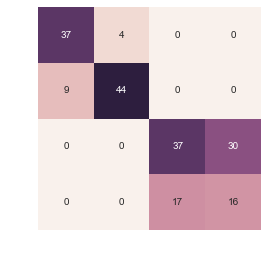

In [18]:
axis_labs = ['Predicted Model', 'Actual Model']
hmap = skmplt.confusion_heatmap(full_test_labels, pred_label, text_labels, 
                                axis_labels = axis_labs, transparent = True,
                               reverse_color = True, filename = "confusion-heatmap-sc1345.png")

NOTE:  the above figure is transparent and white-on-dark for presentation purposes.  The axis labels are there....

## PFG Data Analysis:  Laplacian Eigenvalue Classifier ##

I'm not at all sure we have a good catalog of models that would approximate the regional interaction network of the Lower Mississippi River Valley yet, but we do have three model-classes (the two NN models are essentially indistinguishable given our analysis yere) that are easily distinguishable.  

So let's see what model the optimized model fit chooses.  We do this simply by reading in the GML for the minmax-by-weight seriation solution from IDSS, converting it to the same kind of eigenvalue matrix as the training data, with the same number of eigenvalues as the training data (even though this PFG subset has 20 assemblages), and then using the fitted and optimized gradient boosted tree model to predict the model class, and the probability of class assignment.  

In [19]:
pfg_graph = nx.read_gml("../../data/pfg-cpl-minmax-by-weight-continuity.gml")

In [20]:
pfg_test_mat = skmg.graphs_to_eigenvalue_matrix([pfg_graph], num_eigenvalues=10)

(debug) eigenvalues - minimum shared eigenvalues: 20 num_eigenvalues: 10 ev_used: 10


In [21]:
pfg_predict = grid_search.predict(pfg_test_mat)
print pfg_predict

[1]


In [22]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
probs = grid_search.predict_proba(pfg_test_mat)
probs

array([[ 0.4125,  0.5867,  0.0001,  0.0007]])

Interestingly, there seems to be a vanishingly small probability that the PFG seriation is the result of a pure nearest neighbor model, although the square space seems to fare marginally better than the long, thin space.  But overwhelmingly, the predictive weight is on the lineage splitting model, which makes sense given Carl Lipo's dissertation work.  Less predictive probability comes from the complete graph/fully connected model, although it's still about 0.223, so there's clearly something about densely connected graphs that resonates in the PFG situation (and the lineage splitting model is essentially complete graphs within each lineage too).  

**Clearly**, however, we need a larger catalog of model classes and variants from which to select.  That's next on the todo list.  

## PFG Data Analysis:  Laplacian Distance Similarity ##

In [23]:
gclf = skmg.GraphEigenvalueNearestNeighbors(n_neighbors=5)
gclf.fit(full_train_graphs, full_train_labels)

GraphEigenvalueNearestNeighbors(debug=0, n_neighbors=5, spectral_fraction=0.9)

In [24]:
gclf.predict([pfg_graph])[0]

5

In [25]:
distances = gclf.predict_distance_to_train(pfg_graph)

In [26]:
distances.head()

,distance,model
0,4.483142,0
1,3.862089,0
2,3.764189,0
3,4.559686,1
4,4.216283,1


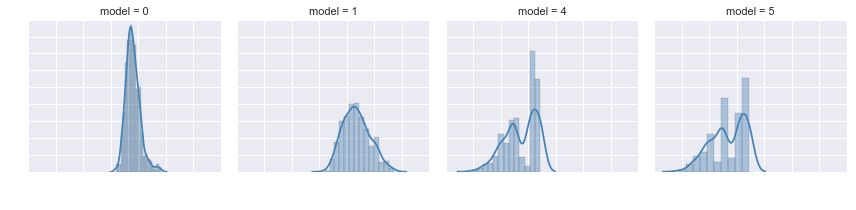

In [27]:
g = sns.FacetGrid(distances, col="model", margin_titles=True)
bins = np.linspace(0, 10, 20)
g.map(sns.distplot, "distance", color="steelblue")

### Dimensionality Reduction ###


In this set of analyses, I have the sense that we have good discrimination between models, but that the PFG empirical data set is possibly outside the border of any of the network models and thus the train/test split is crucial in determining how it classifies.  I'm wondering if we can visualize that, perhaps by doing dimensionality reduction on the eigenvalue data set and then seeing where the PFG data lies in the reduced manifold.  

In [28]:
from sklearn import decomposition
from sklearn import manifold


In [29]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)


In [30]:
X_tsne = tsne.fit_transform(train_matrix)

ValueError: array must not contain infs or NaNs

In [ ]:
plt.figure(figsize=(11,8.5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=full_train_labels, cmap=plt.cm.Spectral)

In [ ]:
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(train_matrix)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=100)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=full_train_labels, cmap=plt.cm.Spectral)

## Graphics for Presentation ##

In [ ]:
test_g = full_test_graphs[16]
plt.figure(figsize=(12,8))
label_map = dict()
for n,d in test_g.nodes_iter(data=True):
    label_map[n] = test_g.node[n]['label'].replace("assemblage-", "")
pos = nx.graphviz_layout(test_g, prog="neato")
nx.draw_networkx(test_g, pos, with_labels=True, labels = label_map)
plt.savefig("test_graph_sc1_5.png", transparent=False)

In [ ]:
full_test_labels[16]